In [1]:
from tensorflow import keras # for building Neural Networks
print('Tensorflow/Keras: %s' % keras.__version__) # print version
from keras.models import Sequential # for creating a linear stack of layers for our Neural Network
from keras import Input # for instantiating a keras tensor
from keras.layers import Bidirectional, GRU, RepeatVector, Dense, TimeDistributed # for creating layers inside the Neural Network

# Data manipulation
import pandas as pd # for data manipulation
print('pandas: %s' % pd.__version__) # print version
import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version

# Sklearn
import sklearn
print('sklearn: %s' % sklearn.__version__) # print version
from sklearn.preprocessing import MinMaxScaler # for feature scaling

# Visualization
import plotly 
import plotly.express as px
import plotly.graph_objects as go
print('plotly: %s' % plotly.__version__) # print version

Tensorflow/Keras: 2.10.0
pandas: 1.4.4
numpy: 1.21.5
sklearn: 1.0.2
plotly: 5.9.0


In [14]:

# Set Pandas options to display more columns
pd.options.display.max_columns=150

# Read in the weather data csv - keep only the columns we need
df=pd.read_csv('all_year.csv', encoding='Big5', usecols=['Date', 'Location', 'MedTemp'])

# Drop records where target MinTemp=NaN or MaxTemp=NaN
df=df[pd.isnull(df['MedTemp'])==False]

# Convert dates to year-months
df['Year-Month']= (pd.to_datetime(df['Date'], yearfirst=True)).dt.strftime('%Y-%m')

# Show a snaphsot of data
df

,Date,Location,Rain,Year
0,1960,A,279.40,1970
1,1961,A,299.80,1970
2,1962,A,291.64,1970
3,1963,A,96.62,1970
4,1964,A,117.26,1970
...,...,...,...,...
56,2016,A,381.56,1970
57,2017,A,230.18,1970
58,2018,A,88.52,1970
59,2019,A,313.96,1970


In [ ]:
# Create a copy of an original dataframe
df2=df[['Location', 'Year-Month', 'MedTemp']].copy()

# Calculate monthly average temperature for each location
df2=df2.groupby(['Location', 'Year-Month'], as_index=False).mean()

# Transpose dataframe 
df2_pivot=df2.pivot(index=['Location'], columns='Year-Month')['MedTemp']

# Remove locations with lots of missing (NaN) data
#df2_pivot=df2_pivot.drop(['Dartmoor', 'Katherine', 'Melbourne', 'Nhil', 'Uluru'], axis=0)

# Remove months with lots of missing (NaN) data
#df2_pivot=df2_pivot.drop(['2007-11', '2007-12', '2008-01', '2008-02', '2008-03', '2008-04', '2008-05', '2008-06', '2008-07', '2008-08', '2008-09', '2008-10', '2008-11', '2008-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06'], axis=1)

# Display the new dataframe
df2_pivot

In [5]:
# Add missing months 2011-04, 2011-04, 2011-04 and impute data
# df2_pivot['2011-04']=(df2_pivot['2011-03']+df2_pivot['2011-05'])/2
# df2_pivot['2012-12']=(df2_pivot['2012-11']+df2_pivot['2013-01'])/2
# df2_pivot['2013-02']=(df2_pivot['2013-01']+df2_pivot['2013-03'])/2

# Sort columns so Year-Months are in the correct order
# df2_pivot=df2_pivot.reindex(sorted(df2_pivot.columns), axis=1)

In [5]:
# Plot average monthly temperature derived from daily medians for each location
fig = go.Figure()
for location in df2_pivot.index:
    fig.add_trace(go.Scatter(x=df2_pivot.loc[location, :].index, 
                             y=df2_pivot.loc[location, :].values,
                             mode='lines',
                             name=location,
                             opacity=0.8,
                             line=dict(width=1)
                            ))

# Change chart background color
fig.update_layout(dict(plot_bgcolor = 'white'), showlegend=True)

# Update axes lines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black',
                 title='Date'
                )

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black',
                 title='Degrees Celsius'
                )

# Set figure title
fig.update_layout(title=dict(text="Average Monthly Temperatures", font=dict(color='black')))

fig.show()

In [6]:
def shaping(datain, timestep, scaler):
    
    # Loop through each location
    for location in datain.index:
        datatmp = datain[datain.index==location].copy()
    
        # Convert input dataframe to array and flatten
        arr=datatmp.to_numpy().flatten() 
        
        # Scale using transform (using previously fitted scaler)
        arr_scaled=scaler.transform(arr.reshape(-1, 1)).flatten()
        
        cnt=0
        for mth in range(0, len(datatmp.columns)-(2*timestep)+1): # Define range 
            cnt=cnt+1 # Gives us the number of samples. Later used to reshape the data
            X_start=mth # Start month for inputs of each sample
            X_end=mth+timestep # End month for inputs of each sample
            Y_start=mth+timestep # Start month for targets of each sample. Note, start is inclusive and end is exclusive, that's why X_end and Y_start is the same number
            Y_end=mth+2*timestep # End month for targets of each sample.  

            # Assemble input and target arrays containing all samples
            if mth==0:
                X_comb=arr_scaled[X_start:X_end]
                Y_comb=arr_scaled[Y_start:Y_end]
            else: 
                X_comb=np.append(X_comb, arr_scaled[X_start:X_end])
                Y_comb=np.append(Y_comb, arr_scaled[Y_start:Y_end])

        # Reshape input and target arrays 
        X_loc=np.reshape(X_comb, (cnt, timestep, 1))
        Y_loc=np.reshape(Y_comb, (cnt, timestep, 1))
        
        # Append an array for each location to the master array
        if location==datain.index[0]:
            X_out=X_loc
            Y_out=Y_loc
        else:
            X_out=np.concatenate((X_out, X_loc), axis=0)
            Y_out=np.concatenate((Y_out, Y_loc), axis=0)
            
    return X_out, Y_out

In [7]:
##### Step 1 - Specify parameters
timestep=2
scaler = MinMaxScaler(feature_range=(-1, 1))

In [8]:
##### Step 2 - Prepare data

# Split data into train and test dataframes
df_train=df2_pivot.iloc[:, 0:-2*timestep].copy()
df_test=df2_pivot.iloc[:, -2*timestep:].copy()

# Use fit to train the scaler on the training data only, actual scaling will be done inside reshaping function
scaler.fit(df_train.to_numpy().reshape(-1, 1))

# Use previously defined shaping function to reshape the data for GRU
X_train, Y_train = shaping(datain=df_train, timestep=timestep, scaler=scaler)
X_test, Y_test = shaping(datain=df_test, timestep=timestep, scaler=scaler)

In [9]:
##### Step 3 - Specify the structure of a Neural Network
model = Sequential(name="GRU-Model") # Model
model.add(Input(shape=(X_train.shape[1],X_train.shape[2]), name='Input-Layer')) # Input Layer - need to speicfy the shape of inputs
model.add(Bidirectional(GRU(units=32, activation='tanh', recurrent_activation='sigmoid', stateful=False), name='Hidden-GRU-Encoder-Layer')) # Encoder Layer
model.add(keras.layers.Dropout(0.2))
model.add(RepeatVector(X_train.shape[1], name='Repeat-Vector-Layer')) # Repeat Vector
model.add(Bidirectional(GRU(units=64, activation='tanh', recurrent_activation='sigmoid', stateful=False, return_sequences=True), name='Hidden-GRU-Decoder-Layer')) # Decoder Layer
model.add(TimeDistributed(Dense(units=1, activation='linear'), name='Output-Layer')) # Output Layer, Linear(x) = x
model.summary()

Model: "GRU-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden-GRU-Encoder-Layer (B  (None, 64)               6720      
 idirectional)                                                   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 Repeat-Vector-Layer (Repeat  (None, 2, 64)            0         
 Vector)                                                         
                                                                 
 Hidden-GRU-Decoder-Layer (B  (None, 2, 128)           49920     
 idirectional)                                                   
                                                                 
 Output-Layer (TimeDistribut  (None, 2, 1)             129       
 ed)                                                     

In [10]:
##### Step 4 - Compile the model
RMSprop = keras.optimizers.RMSprop(learning_rate=0.001,rho=0.9,epsilon=None,decay = 0)
model.compile(optimizer='RMSprop', 
              loss='mean_squared_error', 
              metrics=['mse'], 
              loss_weights=None, # default=None, Optional list or dictionary specifying scalar coefficients (Python floats) to weight the loss contributions of different model outputs.
              weighted_metrics=None, # default=None, List of metrics to be evaluated and weighted by sample_weight or class_weight during training and testing.
              run_eagerly=None, # Defaults to False. If True, this Model's logic will not be wrapped in a tf.function. Recommended to leave this as None unless your Model cannot be run inside a tf.function.
              steps_per_execution=None # Defaults to 1. The number of batches to run during each tf.function call. Running multiple batches inside a single tf.function call can greatly improve performance on TPUs or small models with a large Python overhead.
             )

In [13]:
X_train

array([[[-0.14259004],
        [-0.05177403]],

       [[-0.05177403],
        [-0.08810043]],

       [[-0.08810043],
        [-0.95628367]],

       [[-0.95628367],
        [-0.86439923]],

       [[-0.86439923],
        [-0.39981303]],

       [[-0.39981303],
        [-0.25869207]],

       [[-0.25869207],
        [-0.37221208]],

       [[-0.37221208],
        [-0.22797489]],

       [[-0.22797489],
        [-0.46489783]],

       [[-0.46489783],
        [ 0.09780528]],

       [[ 0.09780528],
        [-0.68659574]],

       [[-0.68659574],
        [-0.95129769]],

       [[-0.95129769],
        [-0.0804434 ]],

       [[-0.0804434 ],
        [ 0.11294128]],

       [[ 0.11294128],
        [ 0.0804434 ]],

       [[ 0.0804434 ],
        [-0.61269643]],

       [[-0.61269643],
        [-1.        ]],

       [[-1.        ],
        [ 0.57859591]],

       [[ 0.57859591],
        [-0.14490495]],

       [[-0.14490495],
        [-0.38013622]],

       [[-0.38013622],
        [-0.55954

In [ ]:
##### Step 5 - Fit the model on the dataset
cb_es = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta = 0  
,patience = 5 , verbose = 0 , mode='min' , baseline=None , restore_best_weights=False)
cb_rl = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1
,patience=5 , verbose=0 , mode="min" , min_delta=0.0001 , cooldown=0 , min_lr=0.0001)
history = model.fit(X_train, # input data
                    Y_train, # target data
                    batch_size=1, # Number of samples per gradient update. If unspecified, batch_size will default to 32.
                    epochs=80, # default=1, Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided
                    verbose=2, # default='auto', ('auto', 0, 1, or 2). Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch. 'auto' defaults to 1 for most cases, but 2 when used with ParameterServerStrategy.
                    callbacks= None, # default=None, list of callbacks to apply during training. See tf.keras.callbacks
                    validation_split=0.2, # default=0.0, Fraction of the training data to be used as validation data. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch. 
                    #validation_data=(X_test, y_test), # default=None, Data on which to evaluate the loss and any model metrics at the end of each epoch. 
                    shuffle=True, # default=True, Boolean (whether to shuffle the training data before each epoch) or str (for 'batch').
                    class_weight=None, # default=None, Optional dictionary mapping class indices (integers) to a weight (float) value, used for weighting the loss function (during training only). This can be useful to tell the model to "pay more attention" to samples from an under-represented class.
                    sample_weight=None, # default=None, Optional Numpy array of weights for the training samples, used for weighting the loss function (during training only).
                    initial_epoch=0, # Integer, default=0, Epoch at which to start training (useful for resuming a previous training run).
                    steps_per_epoch=None, # Integer or None, default=None, Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch. When training with input tensors such as TensorFlow data tensors, the default None is equal to the number of samples in your dataset divided by the batch size, or 1 if that cannot be determined. 
                    validation_steps=None, # Only relevant if validation_data is provided and is a tf.data dataset. Total number of steps (batches of samples) to draw before stopping when performing validation at the end of every epoch.
                    validation_batch_size=None, # Integer or None, default=None, Number of samples per validation batch. If unspecified, will default to batch_size.
                    validation_freq=1, # default=1, Only relevant if validation data is provided. If an integer, specifies how many training epochs to run before a new validation run is performed, e.g. validation_freq=2 runs validation every 2 epochs.
                    max_queue_size=10, # default=10, Used for generator or keras.utils.Sequence input only. Maximum size for the generator queue. If unspecified, max_queue_size will default to 10.
                    workers=1, # default=1, Used for generator or keras.utils.Sequence input only. Maximum number of processes to spin up when using process-based threading. If unspecified, workers will default to 1.
                    use_multiprocessing=True, # default=False, Used for generator or keras.utils.Sequence input only. If True, use process-based threading. If unspecified, use_multiprocessing will default to False. 
                   )


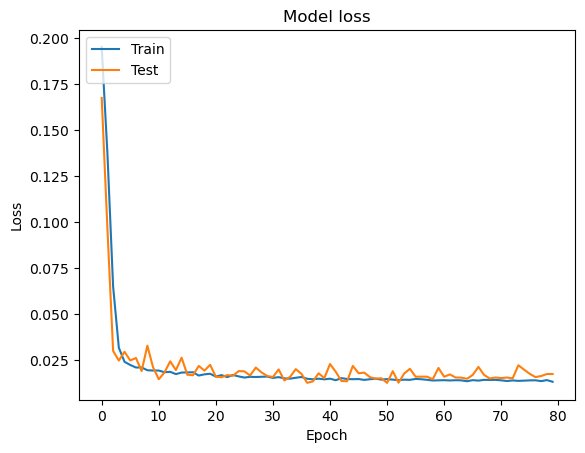

In [11]:
import matplotlib.pyplot as plt
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_acc'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [12]:
##### Step 6 - Use model to make predictions
# Predict results on training data
#pred_train = model.predict(X_train)
# Predict results on test data
pred_test = model.predict(X_test)

1/1 [==============================] - 1s 1s/step


In [13]:
##### Step 7 - Print Performance Summary
print("")
print('-------------------- Model Summary --------------------')
model.summary() # print model summary
print("")
print('-------------------- Weights and Biases --------------------')
print("Too many parameters to print but you can use the code provided if needed")
print("")
#for layer in model.layers:
#    print(layer.name)
#    for item in layer.get_weights():
#        print("  ", item)
#print("")

# Print the last value in the evaluation metrics contained within history file
print('-------------------- Evaluation on Training Data --------------------')
for item in history.history:
    print("Final", item, ":", history.history[item][-1])
print("")

# Evaluate the model on the test data using "evaluate"
print('-------------------- Evaluation on Test Data --------------------')
results = model.evaluate(X_test, Y_test)
print("")


-------------------- Model Summary --------------------
Model: "GRU-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden-GRU-Encoder-Layer (B  (None, 64)               6720      
 idirectional)                                                   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 Repeat-Vector-Layer (Repeat  (None, 12, 64)           0         
 Vector)                                                         
                                                                 
 Hidden-GRU-Decoder-Layer (B  (None, 12, 128)          49920     
 idirectional)                                                   
                                                                 
 Output-Layer (TimeDistribut  (None, 12, 1)            129       


In [14]:
# Select locations to predict temperatures for
location=['Ten_station']
dfloc_test = df_test[df_test.index.isin(location)].copy()

# Reshape test data
X_test, Y_test = shaping(datain=dfloc_test, timestep=timestep, scaler=scaler)

# Predict results on test data
pred_test = model.predict(X_test)


1/1 [==============================] - 0s 33ms/step


In [16]:
fig = go.Figure()

# Trace for actual temperatures
for location in dfloc_test.index:
    fig.add_trace(go.Scatter(x=dfloc_test.loc[location, :].index, 
                             y=dfloc_test.loc[location, :].values,
                             mode='lines',
                             name=location,
                             opacity=0.8,
                             line=dict(width=1)
                            ))

# Trace for predicted temperatures
for i in range(0,pred_test.shape[0]):
    fig.add_trace(go.Scatter(x=np.array(dfloc_test.columns[-timestep:]),
                             # Need to inverse transform the predictions before plotting
                             y=scaler.inverse_transform(pred_test[i].reshape(-1,1)).flatten(), 
                             mode='lines', 
                             name=dfloc_test.index[i]+' Prediction',
                             opacity=1,
                             line=dict(width=2, dash='dot')
                            ))

# Change chart background color
fig.update_layout(dict(plot_bgcolor = 'white'))

# Update axes lines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black',
                 title='Year-Month'
                )

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black',
                 title='Degrees Celsius'
                )

# Set figure title
fig.update_layout(title=dict(text="Average Monthly Temperatures", font=dict(color='black')))
fig.show()